# Introduction
This notebook runs TFT tensorflow2 version on the covid dataset. You can recreate the merged input file using the `Data preparation` notebook. For a fresh model training, remove any files from the `checkpoint` folder.


# Initial Setup
## Importing libraries

In [1]:
import tensorflow as tf
import os, gc, json
import pandas as pd
from pandas import to_datetime

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
# Apply the default theme
sns.set_theme()
sns.set(font_scale = 1.5)

2022-06-21 12:45:23.161552: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import sys
sys.path.append( '../../../v0/' )
from script.utils import train_validation_test_split, scale_back, calculate_result, sumCases
from Class.Trainer import Trainer
from Class.ParameterManager import ParameterManager
from Class.DataProcessor import DataProcessor
from Class.Plotter import PlotResults, PlotWeights

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2022-06-21 12:45:29.213262: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-21 12:45:29.214620: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-06-21 12:45:29.258958: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:88:00.0 name: Tesla V100-PCIE-16GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2022-06-21 12:45:29.258999: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-06-21 12:45:29.264176: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-06-21 12:45:29.264233: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

Run the following if cuda is out of memory

In [6]:
# import torch
# gc.collect()
# torch.cuda.empty_cache()

## Adding google drive
Set `running_on_colab= True` if running on Google colab.

In [7]:
running_on_colab = False

if running_on_colab:
    from google.colab import drive
    drive.mount('/content/drive')

    %cd /content/drive/My Drive/Projects/Covid/TF2

## Setting up folders
The current folder has the following structure

* Rurality_cut.csv
* config.json
* output
  * checkpoints
  * figures

In [8]:
from dataclasses import dataclass

@dataclass
class args:
    # folder where the cleaned feature file are at
    dataPath = 'Rurality_cut.csv'

    outputPath = 'output/'
    configPath = 'config.json'
    checkpoint = os.path.join(outputPath, 'checkpoints')
    restore = False

In [9]:
# output paths
checkpoint_folder = args.checkpoint
figure_folder = os.path.join(args.outputPath, "figures")

# this eventually creates output folder if it doesn't exist
if not os.path.exists(checkpoint_folder):
    os.makedirs(checkpoint_folder, exist_ok=True)

if not os.path.exists(figure_folder):
    os.makedirs(figure_folder, exist_ok=True)

In [10]:
print(f'Loading config.json from {args.configPath}')
with open(args.configPath) as inputfile:
    config = json.load(inputfile)
    inputfile.close()

Loading config.json from config.json


## Load data

In [11]:
print(f'Loading input data from {args.dataPath}')
df = pd.read_csv(args.dataPath)
print(f'Input feature file shape {df.shape}')

Loading input data from Rurality_cut.csv
Input feature file shape (63990, 25)


In [12]:
df['Date'] = to_datetime(df['Date']) 
df['FIPS'] = df['FIPS'].astype(str)

# Pre-processing

## Parameter manager

In [13]:
parameterManager = ParameterManager(config)
print(f'Column mappings: {parameterManager.col_mappings}\n')

Column mappings: {'Static': ['AgeDist', 'AirPollution', 'HealthDisp'], 'ID': ['FIPS'], 'Time': ['TimeFromStart'], 'Target': ['Cases'], 'Future': ['LinearSpace', 'Constant', 'LinearTime', 'P2Time', 'P3Time', 'P4Time', 'CosWeekly', 'SinWeekly'], 'Known Regular': ['AgeDist', 'AirPollution', 'HealthDisp', 'DiseaseSpread', 'Transmission', 'VaccinationFull', 'SocialDist']}



## Train validation test split and Scaling

In [14]:
train_data, validation_data, test_data, target_scaler = train_validation_test_split(df, parameterManager, scale=True)
print(f'Number train data is {train_data.shape[0]}, validation {validation_data.shape[0]}, test {test_data.shape[0]}')

Number train data is 50086, validation 6952, test 6952


## Create batches

In [15]:
dataProcessor = DataProcessor(
    parameterManager.total_sequence_length, parameterManager.col_mappings, parameterManager.data_params
)

train_batch = dataProcessor.prepare_batch(train_data, train=True)
validation_batch = dataProcessor.prepare_batch(validation_data)

gc.collect()

2022-06-21 12:46:21.844157: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-21 12:46:21.844388: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-21 12:46:21.845438: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:88:00.0 name: Tesla V100-PCIE-16GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2022-06-21 12:46:21.845479: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-06-21 12:46:21.845520: I tensorflow/stream_executor/platfor

0

# Training

## Util

In [16]:
def plot_history(history:dict,  figure_path:str=None, show=False):
    fig, ax = plt.subplots(1, 2, figsize=(18, 8), sharex=True)
    x = range(1, len(history['train_loss'])+1)

    # label_text   = [f'{int(loc/1000)}k' for loc in plt.yticks()[0]]
    # ax.set_yticklabels(label_text)

    ax[0].set_title('Training history')
    ax[0].plot(x, history['train_loss'], color='blue', label='Train loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Mean Squared Error of daily covid cases')
    ax[0].legend()

    ax[1].set_title('Validation history')
    ax[1].plot(x, history['validation_loss'], color='green', label='Validation loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean Squared Error of daily covid cases')
    ax[1].legend()

    fig.tight_layout()
    if figure_path:
        plt.savefig(figure_path)
    if show:
        plt.show()

## Create Trainer

In [17]:
trainer = Trainer(parameterManager, disable_progress=False)
model = trainer.create_model()

## Optimizer and Checkpoint

In [18]:
optimizer_params = parameterManager.optimizer_params
optimizer = tf.keras.optimizers.Adam(
    learning_rate=optimizer_params['learning_rate'], clipnorm=optimizer_params['clipnorm']
)

checkpoint = tf.train.Checkpoint(model=model, optimizer=optimizer)
checkpointManager = tf.train.CheckpointManager(checkpoint, checkpoint_folder, max_to_keep=1)

In [19]:
if args.restore and checkpointManager.latest_checkpoint:
    model = trainer.load_from_checkpoint(checkpoint, checkpointManager.latest_checkpoint)
    if model is None:
        sys.exit(-1)

## Training loop

Running the model for 60 epochs.
Epoch 1


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

2022-06-21 12:46:51.223955: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-21 12:46:51.362102: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2600000000 Hz
2022-06-21 12:46:56.060968: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-06-21 12:46:56.293920: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00943492, time 0:01:20.945759. Validation loss 0.0154217, time 0:00:06.586208
Loss improved from inf to 0.00943492

Saving checkpoint for epoch 1 at output/checkpoints/ckpt-1
Epoch 2


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00299699, time 0:00:49.073291. Validation loss 0.0151964, time 0:00:00.824512
Loss improved from 0.00943492 to 0.00299699

Saving checkpoint for epoch 2 at output/checkpoints/ckpt-2
Epoch 3


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00272655, time 0:00:49.323918. Validation loss 0.0160932, time 0:00:00.828630
Loss improved from 0.00299699 to 0.00272655

Saving checkpoint for epoch 3 at output/checkpoints/ckpt-3
Epoch 4


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00254591, time 0:00:49.401816. Validation loss 0.015601, time 0:00:00.843986
Loss improved from 0.00272655 to 0.00254591

Saving checkpoint for epoch 4 at output/checkpoints/ckpt-4
Epoch 5


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00244883, time 0:00:49.384878. Validation loss 0.0152912, time 0:00:00.772439
Loss improved from 0.00254591 to 0.00244883

Saving checkpoint for epoch 5 at output/checkpoints/ckpt-5
Epoch 6


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00240464, time 0:00:49.342375. Validation loss 0.0157126, time 0:00:00.796631
Loss improved from 0.00244883 to 0.00240464

Saving checkpoint for epoch 6 at output/checkpoints/ckpt-6
Epoch 7


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00235283, time 0:00:49.216560. Validation loss 0.0146875, time 0:00:00.801236
Loss improved from 0.00240464 to 0.00235283

Saving checkpoint for epoch 7 at output/checkpoints/ckpt-7
Epoch 8


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00233667, time 0:00:49.031482. Validation loss 0.0150241, time 0:00:00.816749
Loss improved from 0.00235283 to 0.00233667

Saving checkpoint for epoch 8 at output/checkpoints/ckpt-8
Epoch 9


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00231641, time 0:00:49.341607. Validation loss 0.015282, time 0:00:00.796830
Loss improved from 0.00233667 to 0.00231641

Saving checkpoint for epoch 9 at output/checkpoints/ckpt-9
Epoch 10


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00228542, time 0:00:49.109713. Validation loss 0.0149647, time 0:00:00.794125
Loss improved from 0.00231641 to 0.00228542

Saving checkpoint for epoch 10 at output/checkpoints/ckpt-10
Epoch 11


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00226577, time 0:00:49.176995. Validation loss 0.0157249, time 0:00:00.782346
Loss improved from 0.00228542 to 0.00226577

Saving checkpoint for epoch 11 at output/checkpoints/ckpt-11
Epoch 12


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00223425, time 0:00:49.390350. Validation loss 0.015741, time 0:00:00.814515
Loss improved from 0.00226577 to 0.00223425

Saving checkpoint for epoch 12 at output/checkpoints/ckpt-12
Epoch 13


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00221635, time 0:00:49.570066. Validation loss 0.0149599, time 0:00:00.815483
Loss improved from 0.00223425 to 0.00221635

Saving checkpoint for epoch 13 at output/checkpoints/ckpt-13
Epoch 14


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00221109, time 0:00:49.550499. Validation loss 0.0149248, time 0:00:00.834117
Loss improved from 0.00221635 to 0.00221109

Saving checkpoint for epoch 14 at output/checkpoints/ckpt-14
Epoch 15


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00220485, time 0:00:48.929377. Validation loss 0.01447, time 0:00:00.820706
Loss improved from 0.00221109 to 0.00220485

Saving checkpoint for epoch 15 at output/checkpoints/ckpt-15
Epoch 16


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.0021967, time 0:00:49.009297. Validation loss 0.0143353, time 0:00:00.787137
Loss improved from 0.00220485 to 0.0021967

Saving checkpoint for epoch 16 at output/checkpoints/ckpt-16
Epoch 17


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00215695, time 0:00:49.436643. Validation loss 0.0140469, time 0:00:00.769712
Loss improved from 0.0021967 to 0.00215695

Saving checkpoint for epoch 17 at output/checkpoints/ckpt-17
Epoch 18


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00214712, time 0:00:49.522571. Validation loss 0.0138902, time 0:00:00.810066
Loss improved from 0.00215695 to 0.00214712

Saving checkpoint for epoch 18 at output/checkpoints/ckpt-18
Epoch 19


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00211551, time 0:00:49.364967. Validation loss 0.0145241, time 0:00:00.761161
Loss improved from 0.00214712 to 0.00211551

Saving checkpoint for epoch 19 at output/checkpoints/ckpt-19
Epoch 20


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00212162, time 0:00:49.526652. Validation loss 0.0141407, time 0:00:00.802275
Early stop counter 1/60
Epoch 21


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00207467, time 0:00:49.353573. Validation loss 0.0141365, time 0:00:00.826379
Loss improved from 0.00211551 to 0.00207467

Saving checkpoint for epoch 21 at output/checkpoints/ckpt-20
Epoch 22


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00207128, time 0:00:49.685572. Validation loss 0.0141602, time 0:00:00.789215
Loss improved from 0.00207467 to 0.00207128

Saving checkpoint for epoch 22 at output/checkpoints/ckpt-21
Epoch 23


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00204714, time 0:00:49.190345. Validation loss 0.0141917, time 0:00:00.857959
Loss improved from 0.00207128 to 0.00204714

Saving checkpoint for epoch 23 at output/checkpoints/ckpt-22
Epoch 24


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.0020545, time 0:00:49.422213. Validation loss 0.0134722, time 0:00:00.789139
Early stop counter 1/60
Epoch 25


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00202563, time 0:00:49.258898. Validation loss 0.0136597, time 0:00:00.791010
Loss improved from 0.00204714 to 0.00202563

Saving checkpoint for epoch 25 at output/checkpoints/ckpt-23
Epoch 26


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00202211, time 0:00:49.499705. Validation loss 0.0131484, time 0:00:00.831409
Loss improved from 0.00202563 to 0.00202211

Saving checkpoint for epoch 26 at output/checkpoints/ckpt-24
Epoch 27


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00201247, time 0:00:49.483142. Validation loss 0.0132908, time 0:00:00.832357
Loss improved from 0.00202211 to 0.00201247

Saving checkpoint for epoch 27 at output/checkpoints/ckpt-25
Epoch 28


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00199465, time 0:00:49.674461. Validation loss 0.0135773, time 0:00:00.836079
Loss improved from 0.00201247 to 0.00199465

Saving checkpoint for epoch 28 at output/checkpoints/ckpt-26
Epoch 29


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.0019776, time 0:00:49.527098. Validation loss 0.0135982, time 0:00:00.769198
Loss improved from 0.00199465 to 0.0019776

Saving checkpoint for epoch 29 at output/checkpoints/ckpt-27
Epoch 30


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00196059, time 0:00:49.547804. Validation loss 0.0131287, time 0:00:00.820595
Loss improved from 0.0019776 to 0.00196059

Saving checkpoint for epoch 30 at output/checkpoints/ckpt-28
Epoch 31


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00194198, time 0:00:49.386654. Validation loss 0.0130342, time 0:00:00.789703
Loss improved from 0.00196059 to 0.00194198

Saving checkpoint for epoch 31 at output/checkpoints/ckpt-29
Epoch 32


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00193921, time 0:00:49.212196. Validation loss 0.012682, time 0:00:00.817841
Loss improved from 0.00194198 to 0.00193921

Saving checkpoint for epoch 32 at output/checkpoints/ckpt-30
Epoch 33


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00193236, time 0:00:49.064331. Validation loss 0.0127445, time 0:00:00.810418
Loss improved from 0.00193921 to 0.00193236

Saving checkpoint for epoch 33 at output/checkpoints/ckpt-31
Epoch 34


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00191186, time 0:00:49.340108. Validation loss 0.0125756, time 0:00:00.805397
Loss improved from 0.00193236 to 0.00191186

Saving checkpoint for epoch 34 at output/checkpoints/ckpt-32
Epoch 35


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00189852, time 0:00:49.684715. Validation loss 0.0126768, time 0:00:00.812545
Loss improved from 0.00191186 to 0.00189852

Saving checkpoint for epoch 35 at output/checkpoints/ckpt-33
Epoch 36


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00190159, time 0:00:49.745356. Validation loss 0.0129155, time 0:00:00.786513
Early stop counter 1/60
Epoch 37


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00189721, time 0:00:49.398408. Validation loss 0.0131713, time 0:00:00.792559
Loss improved from 0.00189852 to 0.00189721

Saving checkpoint for epoch 37 at output/checkpoints/ckpt-34
Epoch 38


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00186842, time 0:00:49.492787. Validation loss 0.0127569, time 0:00:00.799357
Loss improved from 0.00189721 to 0.00186842

Saving checkpoint for epoch 38 at output/checkpoints/ckpt-35
Epoch 39


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00186467, time 0:00:49.293466. Validation loss 0.0126715, time 0:00:00.849413
Loss improved from 0.00186842 to 0.00186467

Saving checkpoint for epoch 39 at output/checkpoints/ckpt-36
Epoch 40


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00184541, time 0:00:49.248072. Validation loss 0.0129489, time 0:00:00.785875
Loss improved from 0.00186467 to 0.00184541

Saving checkpoint for epoch 40 at output/checkpoints/ckpt-37
Epoch 41


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00182365, time 0:00:49.229615. Validation loss 0.0129686, time 0:00:00.838626
Loss improved from 0.00184541 to 0.00182365

Saving checkpoint for epoch 41 at output/checkpoints/ckpt-38
Epoch 42


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00182147, time 0:00:49.455240. Validation loss 0.012902, time 0:00:00.789403
Loss improved from 0.00182365 to 0.00182147

Saving checkpoint for epoch 42 at output/checkpoints/ckpt-39
Epoch 43


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00181129, time 0:00:49.275432. Validation loss 0.0128615, time 0:00:00.807139
Loss improved from 0.00182147 to 0.00181129

Saving checkpoint for epoch 43 at output/checkpoints/ckpt-40
Epoch 44


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00181349, time 0:00:49.551771. Validation loss 0.0132332, time 0:00:00.764708
Early stop counter 1/60
Epoch 45


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00178786, time 0:00:49.199137. Validation loss 0.0128656, time 0:00:00.816017
Loss improved from 0.00181129 to 0.00178786

Saving checkpoint for epoch 45 at output/checkpoints/ckpt-41
Epoch 46


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00181436, time 0:00:49.200970. Validation loss 0.0128799, time 0:00:00.755447
Early stop counter 1/60
Epoch 47


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00177372, time 0:00:49.080677. Validation loss 0.0130841, time 0:00:00.815353
Loss improved from 0.00178786 to 0.00177372

Saving checkpoint for epoch 47 at output/checkpoints/ckpt-42
Epoch 48


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00177118, time 0:00:49.247776. Validation loss 0.0129558, time 0:00:00.836036
Loss improved from 0.00177372 to 0.00177118

Saving checkpoint for epoch 48 at output/checkpoints/ckpt-43
Epoch 49


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00175351, time 0:00:49.295287. Validation loss 0.0130686, time 0:00:00.812559
Loss improved from 0.00177118 to 0.00175351

Saving checkpoint for epoch 49 at output/checkpoints/ckpt-44
Epoch 50


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00174905, time 0:00:49.160237. Validation loss 0.01325, time 0:00:00.763135
Loss improved from 0.00175351 to 0.00174905

Saving checkpoint for epoch 50 at output/checkpoints/ckpt-45
Epoch 51


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00174331, time 0:00:49.216658. Validation loss 0.0129109, time 0:00:00.775433
Loss improved from 0.00174905 to 0.00174331

Saving checkpoint for epoch 51 at output/checkpoints/ckpt-46
Epoch 52


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00173368, time 0:00:49.366738. Validation loss 0.0130293, time 0:00:00.786235
Loss improved from 0.00174331 to 0.00173368

Saving checkpoint for epoch 52 at output/checkpoints/ckpt-47
Epoch 53


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00171683, time 0:00:49.108008. Validation loss 0.0131555, time 0:00:00.754913
Loss improved from 0.00173368 to 0.00171683

Saving checkpoint for epoch 53 at output/checkpoints/ckpt-48
Epoch 54


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00172261, time 0:00:49.359189. Validation loss 0.0132773, time 0:00:00.781075
Early stop counter 1/60
Epoch 55


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00170602, time 0:00:49.757489. Validation loss 0.0131507, time 0:00:00.783918
Loss improved from 0.00171683 to 0.00170602

Saving checkpoint for epoch 55 at output/checkpoints/ckpt-49
Epoch 56


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.0017206, time 0:00:49.403007. Validation loss 0.0130506, time 0:00:00.794075
Early stop counter 1/60
Epoch 57


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00169225, time 0:00:49.159453. Validation loss 0.0130036, time 0:00:00.801599
Loss improved from 0.00170602 to 0.00169225

Saving checkpoint for epoch 57 at output/checkpoints/ckpt-50
Epoch 58


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00168081, time 0:00:49.292750. Validation loss 0.0131156, time 0:00:00.821557
Loss improved from 0.00169225 to 0.00168081

Saving checkpoint for epoch 58 at output/checkpoints/ckpt-51
Epoch 59


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.0016723, time 0:00:49.361052. Validation loss 0.0128315, time 0:00:00.788443
Loss improved from 0.00168081 to 0.0016723

Saving checkpoint for epoch 59 at output/checkpoints/ckpt-52
Epoch 60


Train:   0%|          | 0/750 [00:00<?, ?it/s]

Validation:   0%|          | 0/76 [00:00<?, ?it/s]

Train loss 0.00166923, time 0:00:49.535781. Validation loss 0.012913, time 0:00:00.836521
Loss improved from 0.0016723 to 0.00166923

Saving checkpoint for epoch 60 at output/checkpoints/ckpt-53


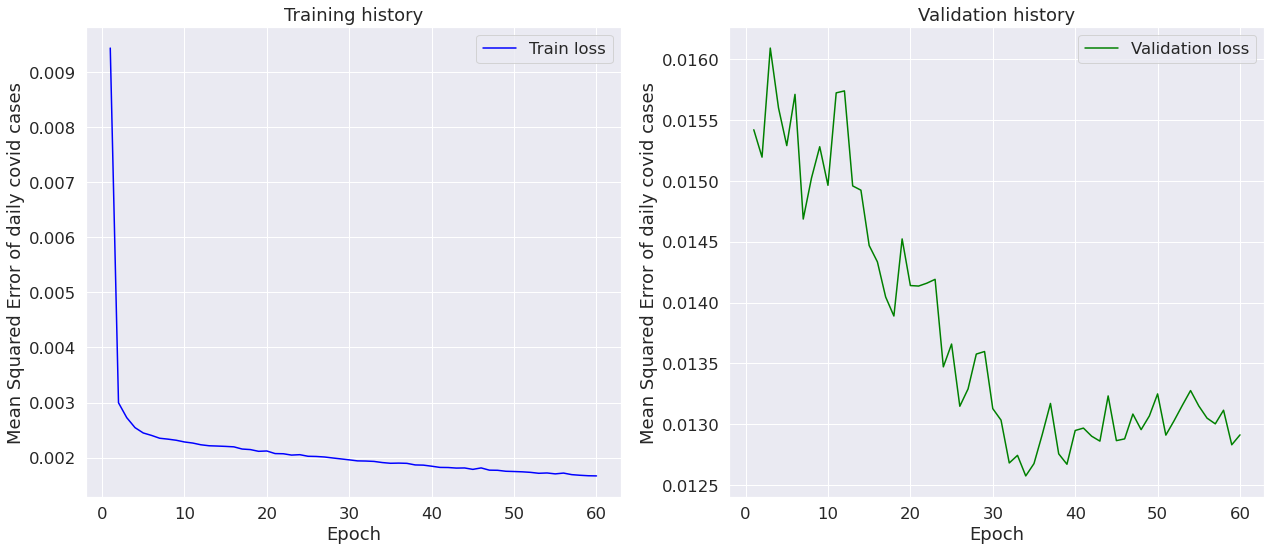

6549

In [20]:
history = trainer.fit(
    model, optimizer, train_batch, validation_batch, checkpointManager, early_stopping_patience=parameterManager.early_stopping_patience
)

plot_history(history, os.path.join(figure_folder, 'history.png'), show=True)
gc.collect()

## Testing

In [21]:
# load the best checkpoint by validation loss
model = trainer.load_from_checkpoint(checkpoint, checkpointManager.latest_checkpoint)
if model is None:
    sys.exit(-1)

Checkpoint restored from output/checkpoints/ckpt-53


### Train predictions

In [22]:
train_batch = dataProcessor.prepare_batch(train_data)
train_preds, train_actuals, train_attn_weights = trainer.predict(model, train_batch)

train_actuals = scale_back(train_actuals, target_scaler, parameterManager.target_sequence_length)
train_preds = scale_back(train_preds, target_scaler, parameterManager.target_sequence_length)

train_mae, train_rmse, train_smape = calculate_result(train_actuals, train_preds)
print(f'Train MAE {train_mae}, RMSE {train_rmse}, SMAPE {train_smape}')
gc.collect()

  0%|          | 0/750 [00:00<?, ?it/s]

Train MAE 6.1993, RMSE 14.9135, SMAPE 1.093


20

### Validation predictions

In [23]:
validation_preds, validation_actuals, _ = trainer.predict(model, validation_batch)

validation_preds = scale_back(validation_preds, target_scaler, parameterManager.target_sequence_length)
validation_actuals = scale_back(validation_actuals,  target_scaler, parameterManager.target_sequence_length)

validation_mae, validation_rmse, validation_smape = calculate_result(validation_actuals, validation_preds)
print(f'Validation MAE {validation_mae}, RMSE {validation_rmse}, SMAPE {validation_smape}')

  0%|          | 0/76 [00:00<?, ?it/s]

Validation MAE 28.1808, RMSE 65.6624, SMAPE 1.3219


### Test

In [24]:
test_batch = dataProcessor.prepare_batch(test_data)
test_preds, test_actuals, _ = trainer.predict(model, test_batch)

test_actuals = scale_back(test_actuals, target_scaler, parameterManager.target_sequence_length) 
test_preds = scale_back(test_preds, target_scaler, parameterManager.target_sequence_length)

test_mae, test_rmse, test_smape = calculate_result(test_actuals, test_preds)
print(f'Test MAE {test_mae}, RMSE {test_rmse}, SMAPE {test_smape}')

  0%|          | 0/76 [00:00<?, ?it/s]

Test MAE 10.0567, RMSE 15.9588, SMAPE 1.6016


### Delete model

In [25]:
del model
gc.collect()

40

# Result plot

In [26]:
number_of_locations = df[parameterManager.col_mappings['ID']].nunique().values[0]
print(f'Number of locations {number_of_locations}')
locs = df[parameterManager.col_mappings['ID']].iloc[:number_of_locations, 0].values

Number of locations 79


## Train

Saving output/figures/Summed plot - train.png


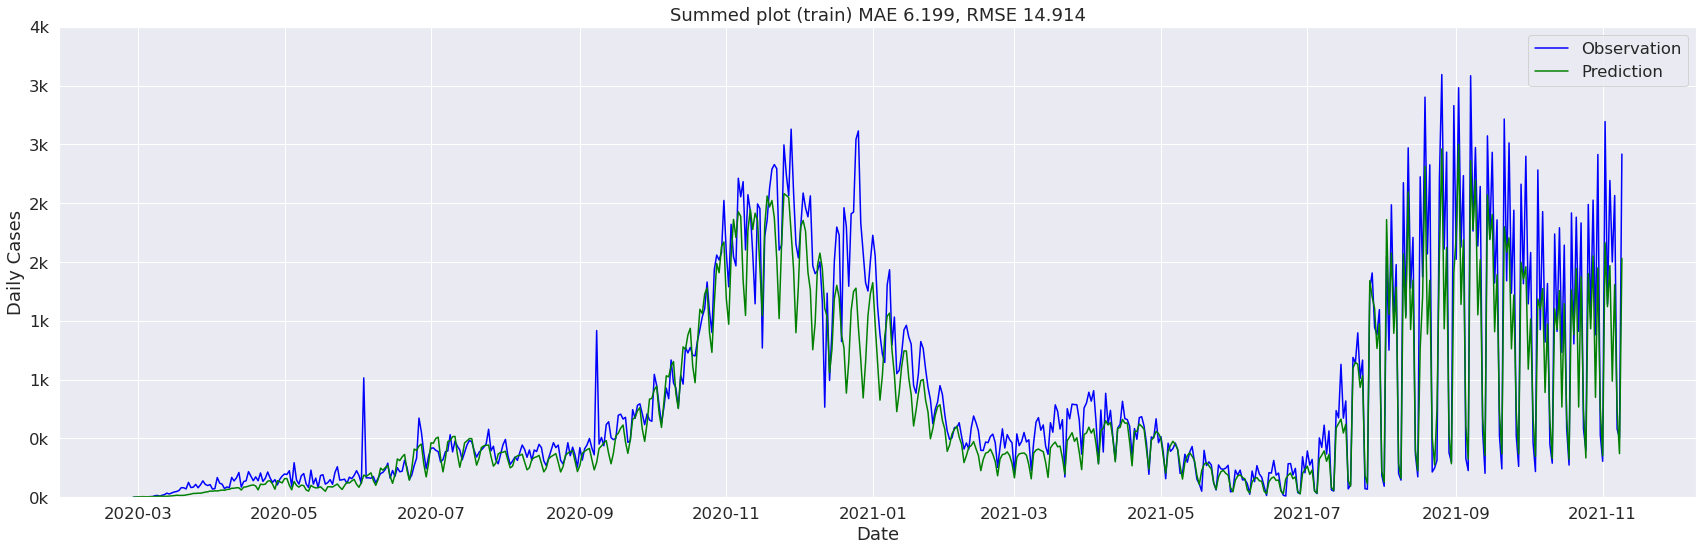

In [27]:
targets, predictions = sumCases(train_actuals, train_preds, number_of_locations)

resultPlotter = PlotResults(targets, predictions, parameterManager.train_start, locs, figure_folder)
plot_title = f'Summed plot (train) MAE {train_mae:0.3f}, RMSE {train_rmse:0.3f}'

resultPlotter.makeSummedPlot(plot_title, figure_name='Summed plot - train', figsize=(24, 8))

## Validation

Saving output/figures/Summed plot - validation.png


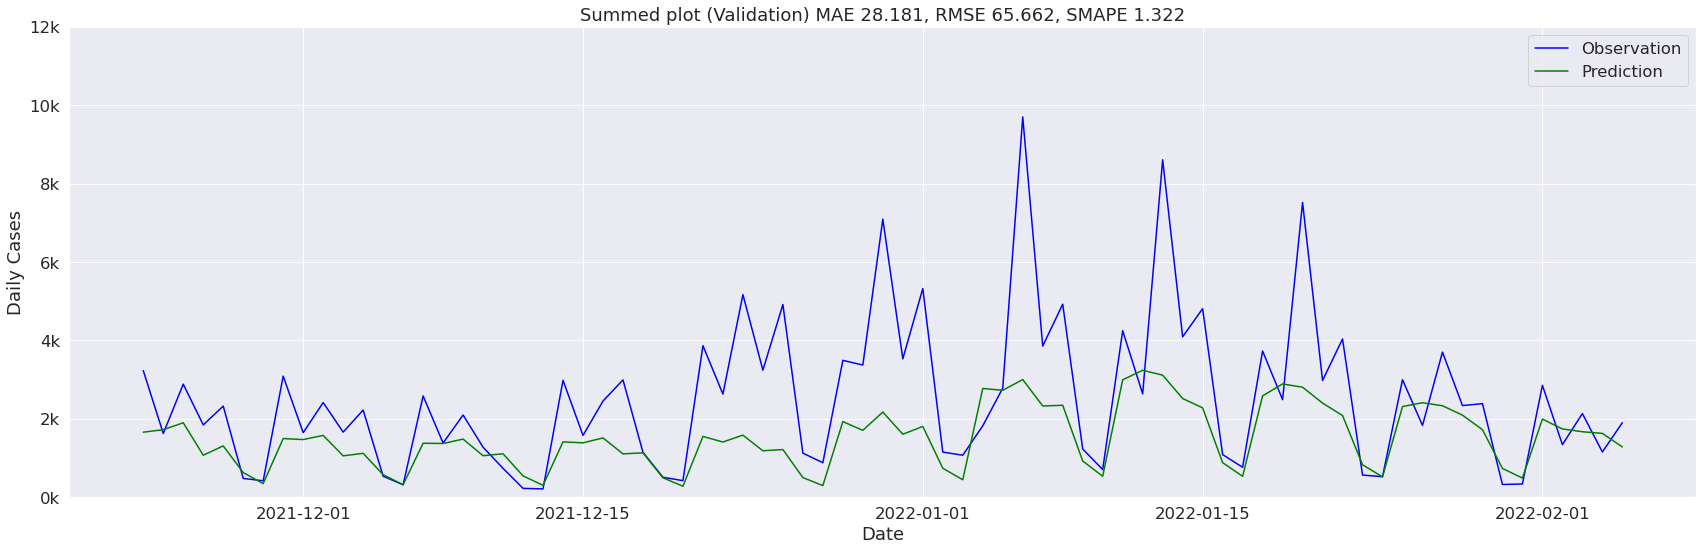

In [28]:
targets, predictions = sumCases(validation_actuals, validation_preds, number_of_locations)
resultPlotter = PlotResults(targets, predictions, parameterManager.validation_start, locs, figure_folder)
plot_title = f'Summed plot (Validation) MAE {validation_mae:0.3f}, RMSE {validation_rmse:0.3f}, SMAPE {validation_smape:0.3f}'

resultPlotter.makeSummedPlot(plot_title, figure_name='Summed plot - validation')

## Test

Saving output/figures/Summed plot - test.png


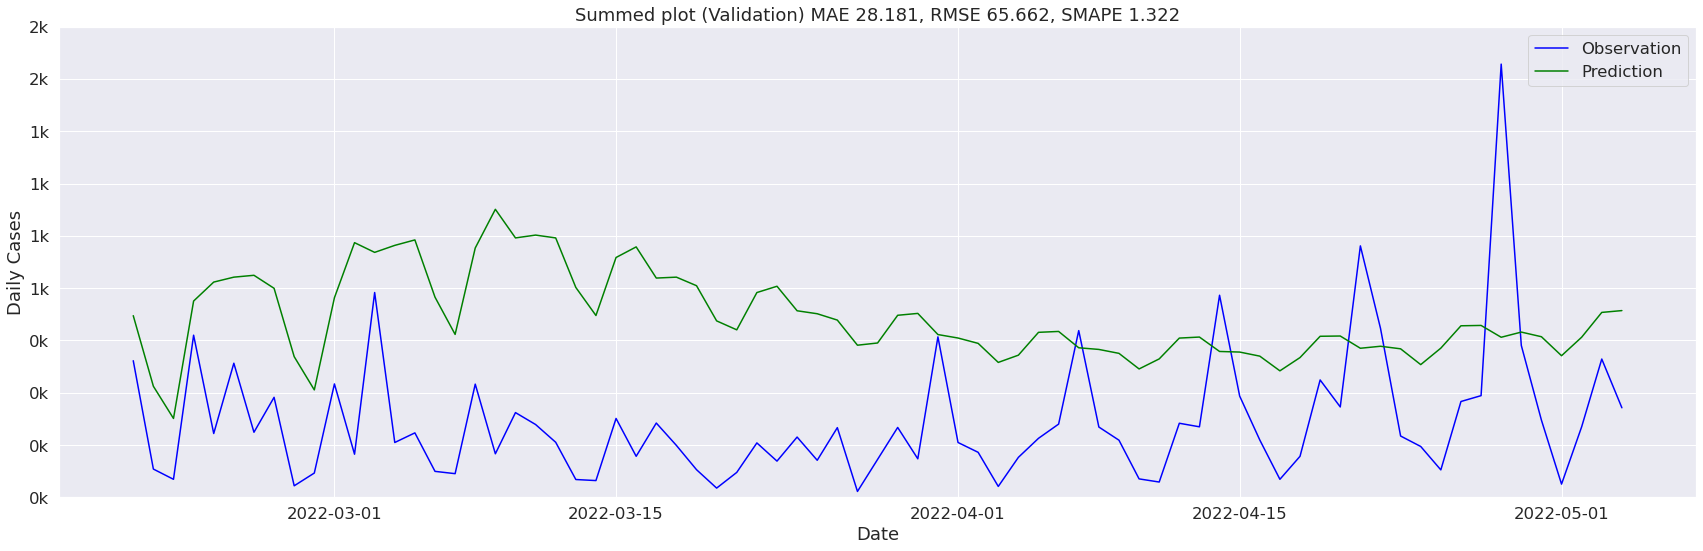

In [29]:
targets, predictions = sumCases(test_actuals, test_preds, number_of_locations)
PlotC = PlotResults(targets, predictions, parameterManager.test_start, locs, figure_folder)
plot_title = f'Summed plot (Validation) MAE {validation_mae:0.3f}, RMSE {validation_rmse:0.3f}, SMAPE {validation_smape:0.3f}'

PlotC.makeSummedPlot(plot_title, figure_name='Summed plot - test')

# Interpret

Saving output/figures/Static input selection weights by variable.png


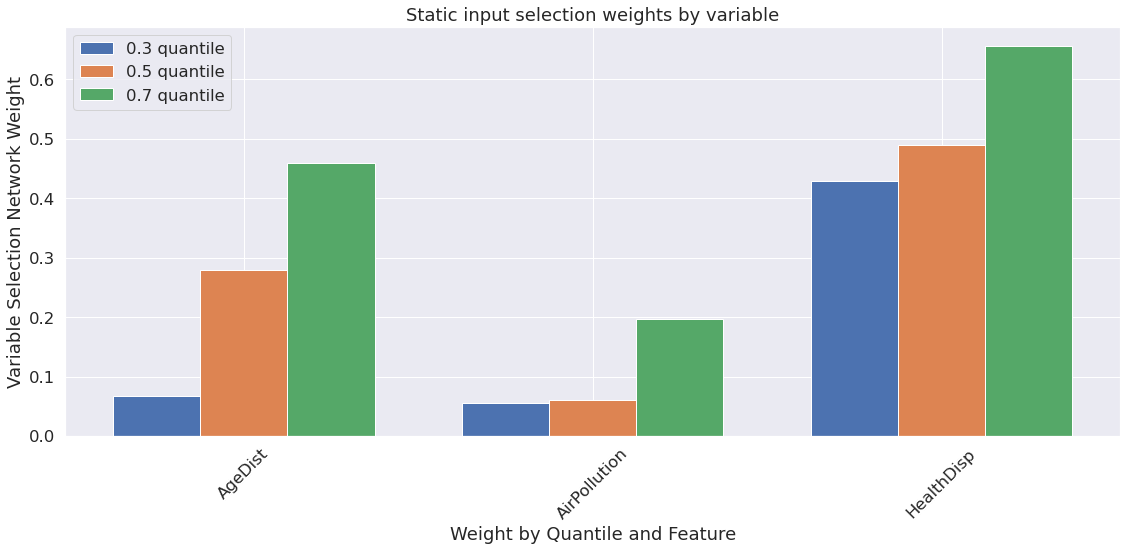

Saving output/figures/Future known input selection weights by variable.png


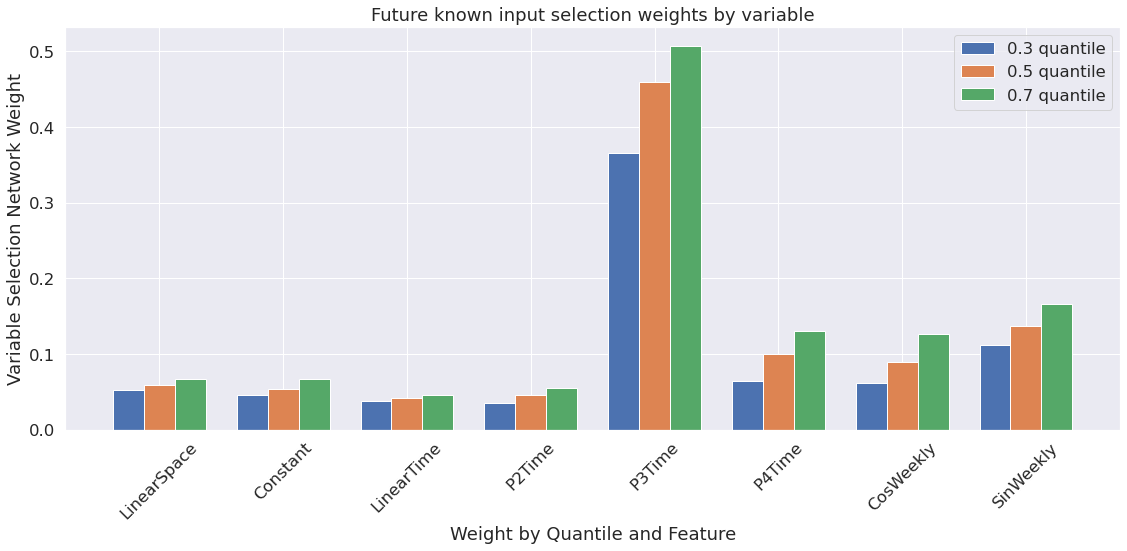

Saving output/figures/Observed input selection weights by variable.png


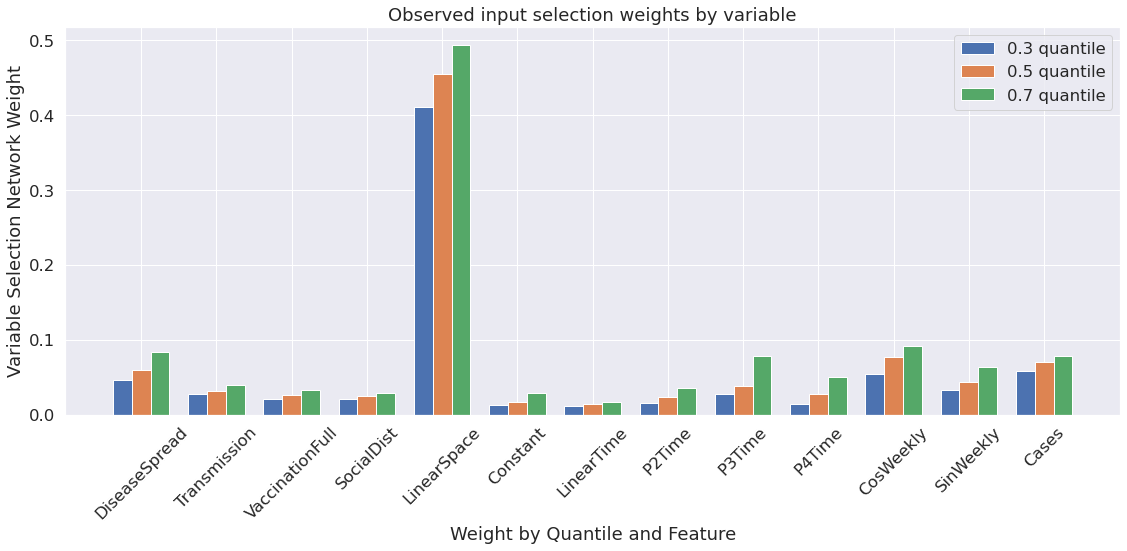

In [30]:
plotter = PlotWeights(parameterManager.col_mappings, train_attn_weights, figure_folder, show=True)
"""## Static variables"""

plotter.plot_static_weights()

"""## Future known input"""

plotter.plot_future_weights()

"""## Observed weights"""

plotter.plotObservedWeights()